# Exponential-family EKF

$$
\begin{aligned}
    p(\theta_t \vert \theta_{t-1}) &= {\cal N}(\theta_t \vert \theta_{t-1}, Q_t)\\
    p(y_t \vert \theta_{t}, {\bf x}_t) &= \text{expfam}(y_t \vert h(\theta_t, {\bf x}_t))\\
\end{aligned}
$$

In [2]:
import jax
import chex
import einops
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from jax.flatten_util import ravel_pytree
from matplotlib.animation import FuncAnimation

# !pip install git+https://github.com/gerdm/rebayes-mini
from rebayes_mini.methods import extended_kalman_filter as ekf

In [3]:
%config InlineBackend.figure_format = "retina"

## Bernoulli

Log-partition is given by

$$
    A(\eta) = \log(1 + \exp(\eta))
$$

In [5]:
n_samples = 200
data = make_moons(n_samples=n_samples, random_state=314, noise=0.15)
X, y = jax.tree_map(jnp.array, data)

key = jax.random.PRNGKey(314)

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x # Eta
    
model = MLP()
params = model.init(key, X)

In [8]:
@jax.jit
def log_partition(eta):
    return jnp.log(1 + jnp.exp(eta)).sum()

@jax.jit
def suff_stat(y):
    return y


agent = ekf.ExpfamExtendedKalmanFilter(
    model.apply,
    log_partition,
    suff_stat,
    dynamics_covariance=0.0
)

bel_init = agent.init_bel(params, cov=2.0)
bel, bel_hist = agent.scan(bel_init, X, y)

In [9]:
eta = agent.apply_fn(bel.mean, X)
yhat = jax.nn.sigmoid(eta) > 0.5

In [10]:
(y == yhat.squeeze()).mean()

Array(0.935, dtype=float32)

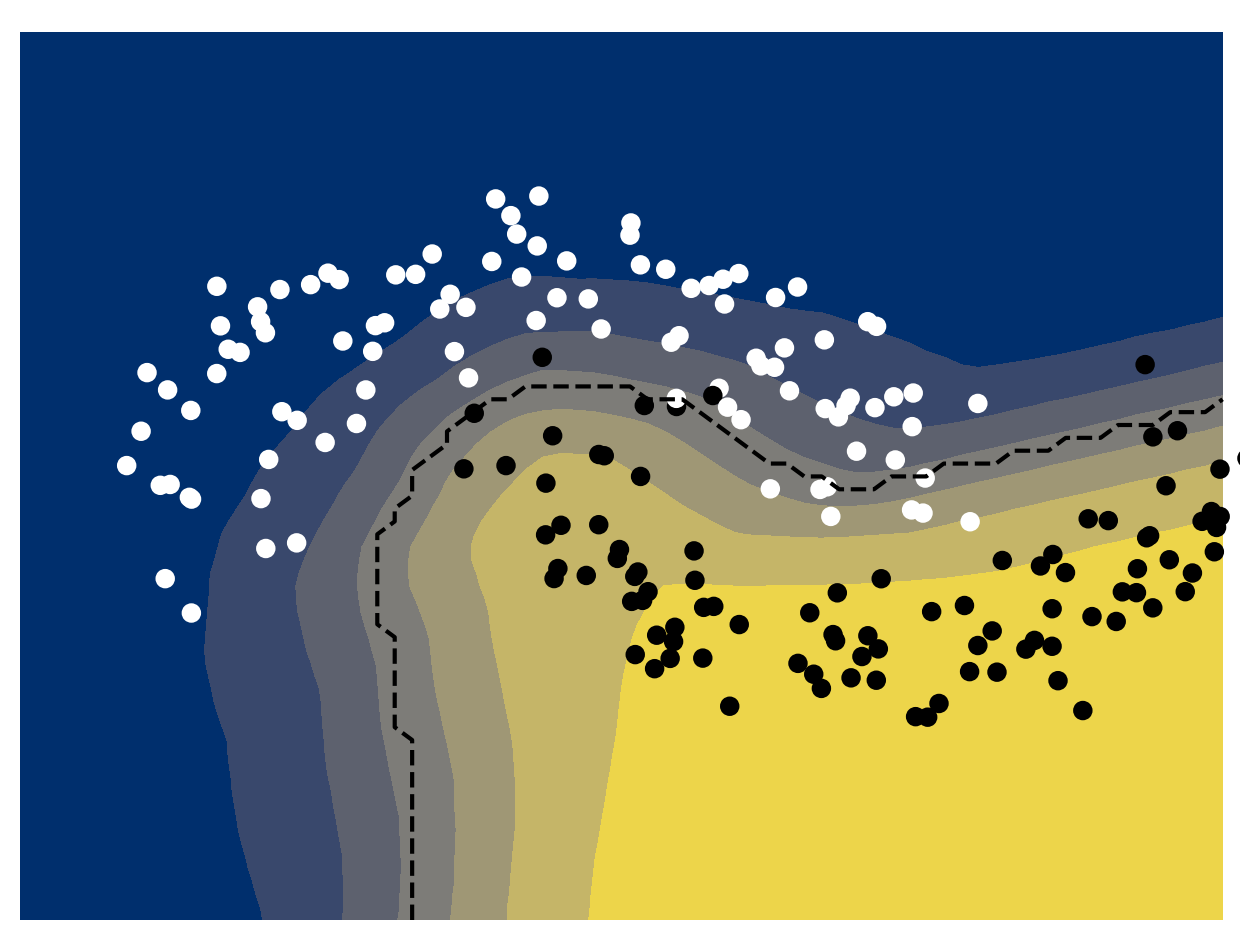

In [21]:
XX = np.mgrid[-1.5:2:0.05, -1.5:2:0.05]

Xeval = einops.rearrange(XX, "d x y -> x y d")

Z = agent.apply_fn(bel.mean, Xeval).squeeze()
mean_Z = agent.mean(Z)

plt.contourf(*XX, mean_Z, cmap="cividis")
plt.contour(*XX, mean_Z > 0.5, colors="black", linestyles="--")
plt.scatter(*np.array(X).T, c=y, cmap="bone_r")
plt.ylim(-1.5, 2)
plt.xlim(-1.5, 2)
plt.axis("off")
plt.tight_layout()

## Animating

MovieWriter ffmpeg unavailable; using Pillow instead.
/tmp/ipykernel_3856365/124652209.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


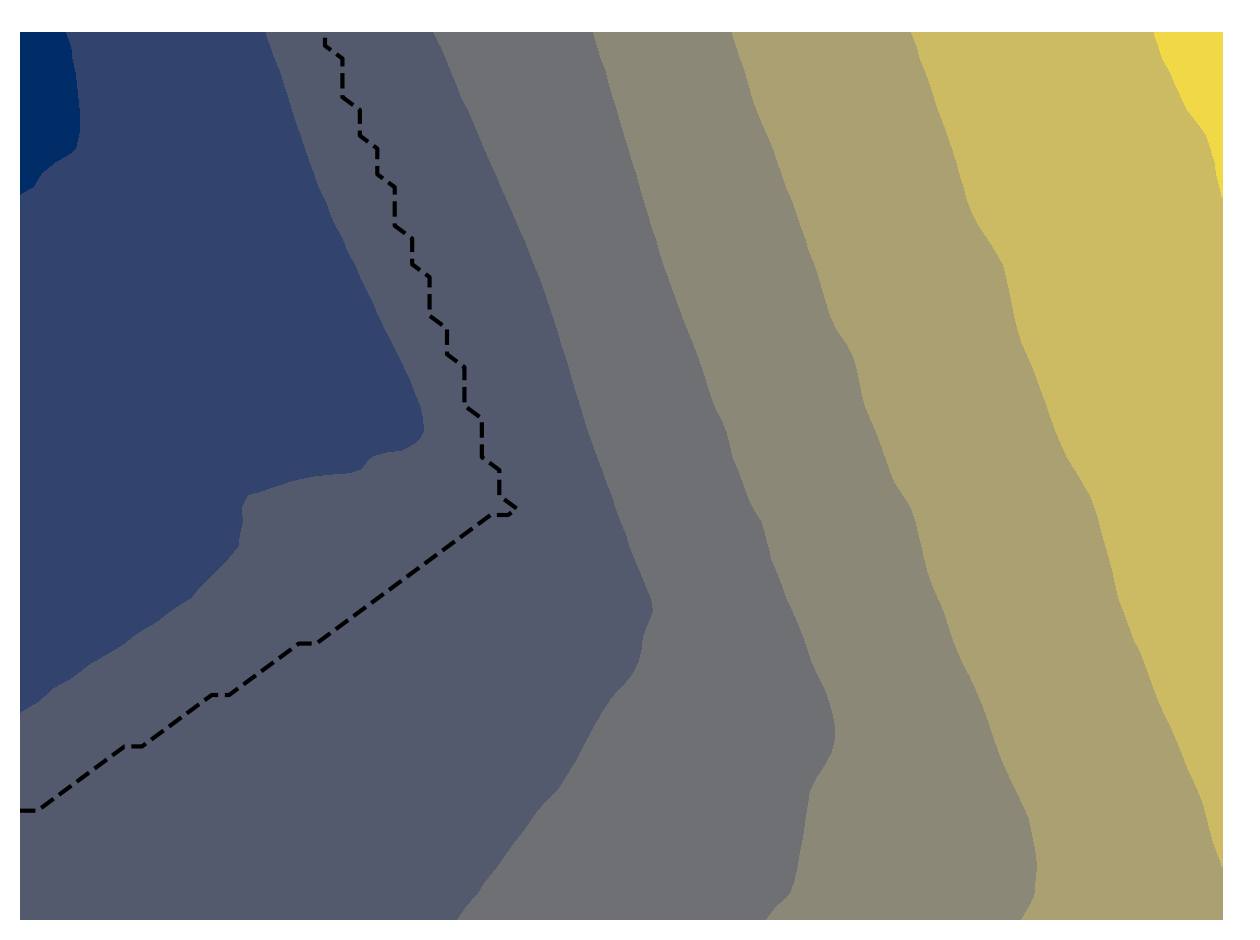

In [23]:
fig, ax = plt.subplots()

def anim(t):
    ax.cla()
    bel = jax.tree_map(lambda x: x[t], bel_hist)
    Z = np.array(agent.apply_fn(bel.mean, Xeval).squeeze())
    mean_Z = agent.mean(Z)
    plt.contourf(*XX, mean_Z, cmap="cividis")
    plt.contour(*XX, mean_Z > 0.5, colors="black", linestyles="--")
    plt.scatter(*np.array(X)[:t].T, c=y[:t], cmap="bone_r")
    plt.ylim(-1.5, 2)
    plt.xlim(-1.5, 2)
    plt.axis("off")
    plt.tight_layout()

frames = np.arange(n_samples)
animation = FuncAnimation(fig, anim, frames=frames)
animation.save("bern-ekf.gif", fps=20)

# Gaussian: Heteroskedastic

Log-partition is given by

$$
    A(\boldsymbol\eta) = A(\eta_1, \eta_2) = -\frac{\eta_1^2}{4\eta_2} - \frac{1}{2}\log(-2\eta_2)
$$

In [188]:
def basis_transform(domain):
    return jnp.c_[domain, domain ** 2]

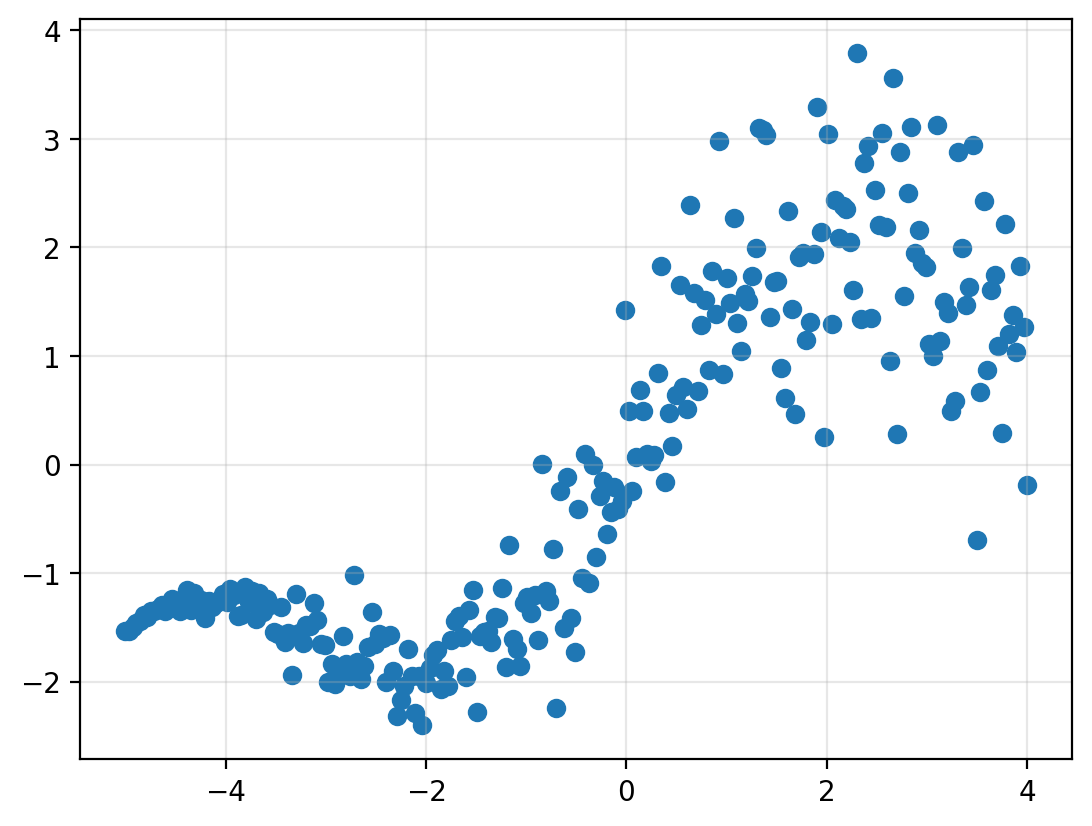

In [411]:
key = jax.random.PRNGKey(314)
key_data, key_train = jax.random.split(key)

n_samples = 250
key_x, key_y = jax.random.split(key_data)

key_noise, key_y = jax.random.split(key_y)
err = jax.random.normal(key_y, (n_samples,))

x = jnp.linspace(-5, 4, n_samples)

scales = jnp.linspace(0.01, 1.0, n_samples)
# scales = np.sqrt(jnp.exp(x / 2))
err = err * scales


y_clean = 0.5 * x + jnp.sin(x)
y = y_clean + err

ixs_new = jax.random.choice(key_x, n_samples, (n_samples,), replace=False)
x, y = x[ixs_new], y[ixs_new]
y_clean = y_clean[ixs_new]

X = basis_transform(x[:, None])

plt.scatter(x, y)
plt.grid(alpha=0.3)

In [412]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        
        eta1 = nn.Dense(50)(x)
        eta1 = nn.relu(eta1)
        eta1 = nn.Dense(1)(eta1)
        
        eta2 = nn.Dense(50)(x)
        eta2 = nn.relu(eta2)
        eta2 = nn.Dense(1)(eta2)
        
        eta = jnp.array([eta1, -jnp.exp(eta2)]).squeeze()
        return eta
    
model = MLP()
params = model.init(key_train, X)

In [426]:
@jax.jit
def log_partition(eta):
    eta1, eta2 = eta
    return -eta1 ** 2 / (4 * eta2) - jnp.log(-2 * eta2) / 2

@jax.jit
def suff_stat(y):
    return jnp.array([y, y ** 2])

agent = ekf.ExpfamExtendedKalmanFilter(
    model.apply,
    log_partition,
    suff_stat,
    dynamics_covariance=0.0
)

bel_init = agent.init_bel(params, cov=1e-2)
bel, bel_hist = agent.scan(bel_init, X, y)

In [427]:
%%time

xeval = jnp.linspace(-5, 4, 200)
Xeval = basis_transform(xeval[:, None])
eta_eval = agent.apply_fn(bel.mean, Xeval)
preds_eval = jax.vmap(agent.mean, 1)(eta_eval)
preds_eval = jax.tree_map(np.array, preds_eval)

CPU times: user 258 ms, sys: 2.45 ms, total: 261 ms
Wall time: 6.75 s


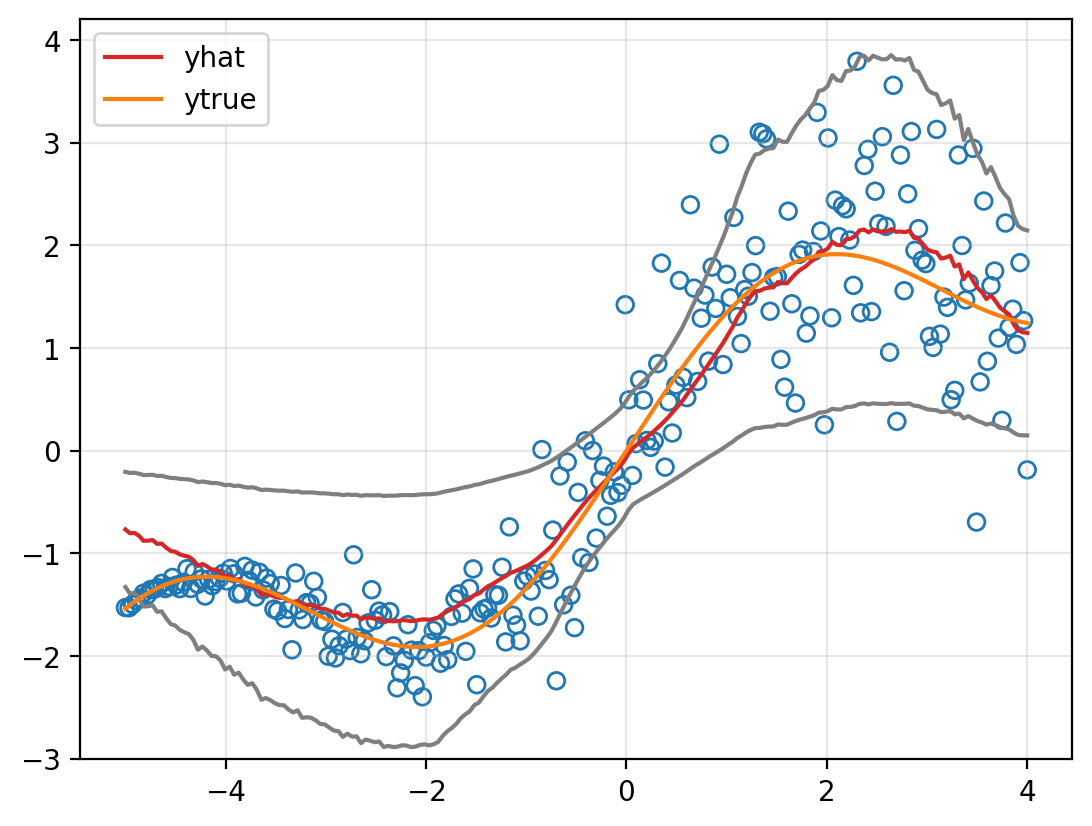

In [428]:
mean_eval = preds_eval[:, 0]
std_eval = jnp.sqrt(preds_eval[:, 1]/2)

plt.plot(np.array(xeval), mean_eval + std_eval, c="tab:gray")
plt.plot(np.array(xeval), mean_eval - std_eval, c="tab:gray")

plt.plot(xeval, mean_eval, c="tab:red", label="yhat")
plt.plot(xeval, xeval / 2 + jnp.sin(xeval), c="tab:orange", label="ytrue")
plt.scatter(x, y, edgecolor="tab:blue", color="none")
plt.legend()
plt.ylim(-3, 4.2)
plt.grid(alpha=0.3)

In [431]:
eta = agent.apply_fn(bel.mean, X)
preds = jax.vmap(agent.mean, 1)(eta)

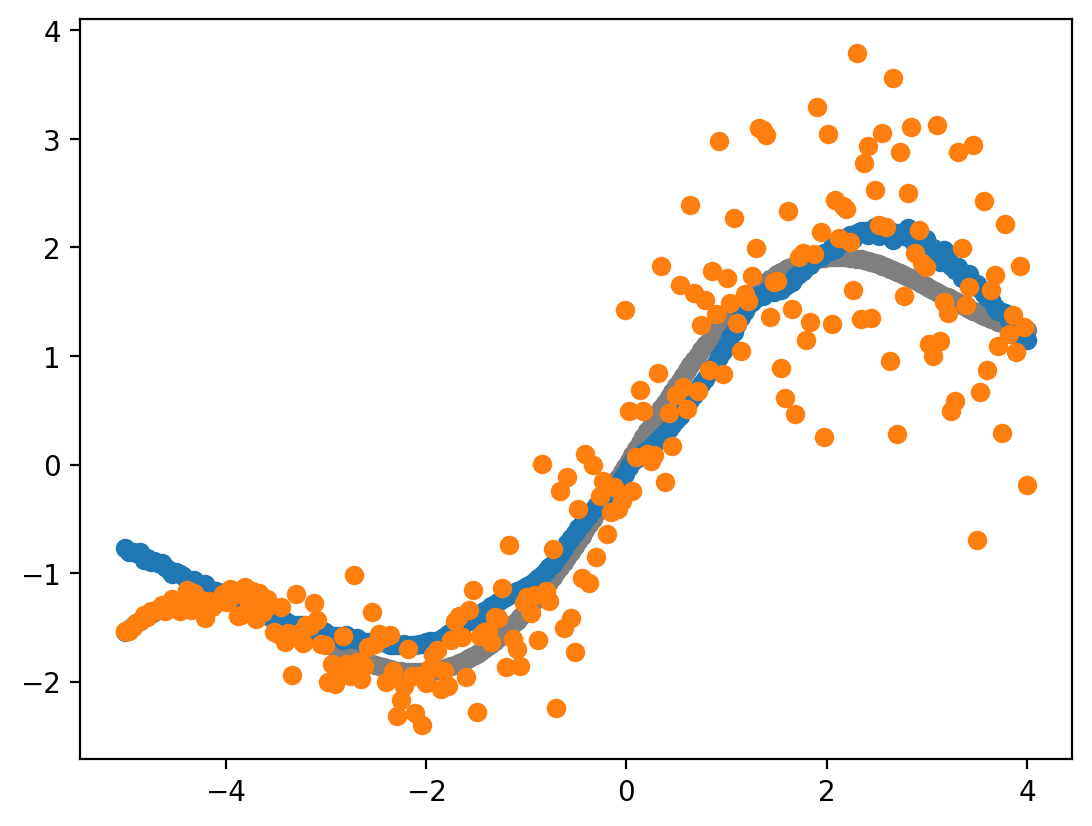

In [433]:
plt.scatter(x, y_clean, c="tab:gray")
plt.scatter(x, preds[:, 0])
plt.scatter(x, y)

## Animating

MovieWriter ffmpeg unavailable; using Pillow instead.


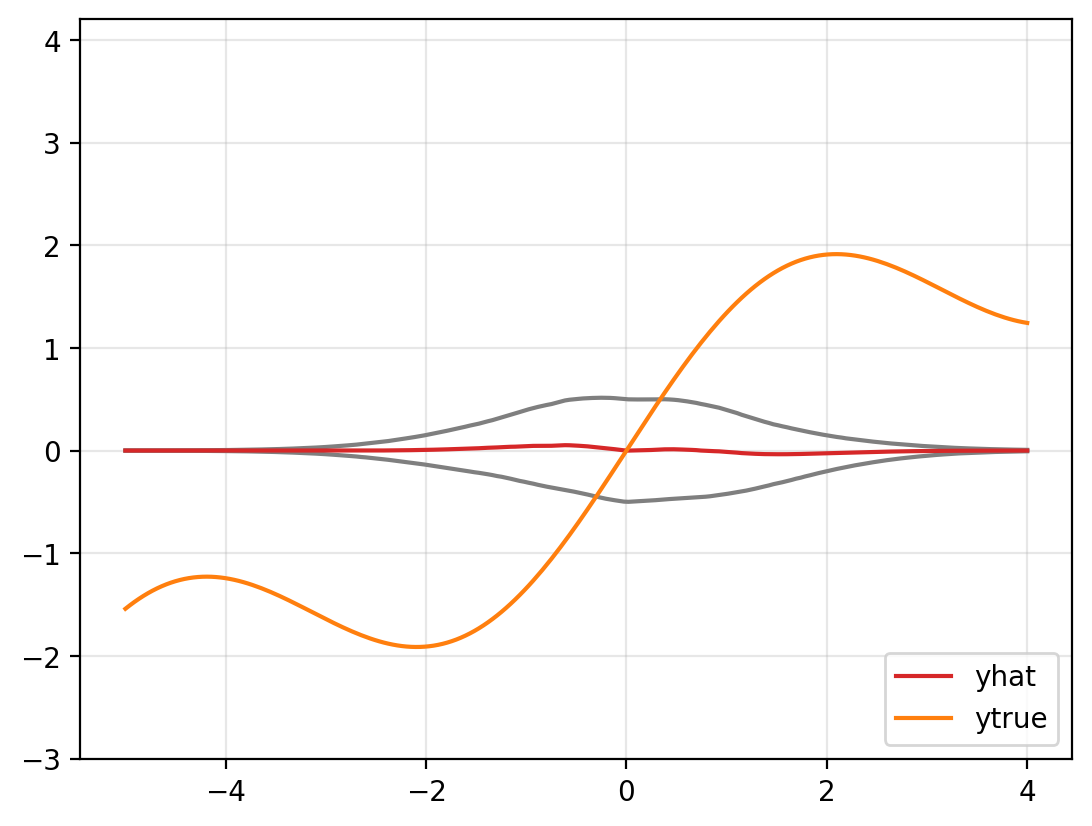

In [434]:
fig, ax = plt.subplots()

def anim(t):
    ax.cla()
    bel = jax.tree_map(lambda x: x[t], bel_hist)
    eta_eval = agent.apply_fn(bel.mean, Xeval)
    preds_eval = jax.vmap(agent.mean, 1)(eta_eval)
    preds_eval = jax.tree_map(np.array, preds_eval)

    mean_eval = preds_eval[:, 0]
    std_eval = jnp.sqrt(preds_eval[:, 1] / 2)

    plt.plot(np.array(xeval), mean_eval + std_eval, c="tab:gray")
    plt.plot(np.array(xeval), mean_eval - std_eval, c="tab:gray")

    plt.plot(xeval, mean_eval, c="tab:red", label="yhat")
    plt.plot(xeval, xeval / 2 + jnp.sin(xeval), c="tab:orange", label="ytrue")
    plt.scatter(x[:t], y[:t], edgecolor="tab:blue", color="none")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.ylim(-3, 4.2)

frames = np.arange(n_samples)
animation = FuncAnimation(fig, anim, frames=frames)
animation.save("hetgauss-ekf.gif", fps=20)

# References
* [The Extended Kalman Filter is a Natural Gradient Descent in Trajectory Space](http://www.yann-ollivier.org/rech/publs/kalnat.pdf)
* [Table of exponential families](https://en.wikipedia.org/wiki/Exponential_family#Table_of_distributions)